# Current Industry Exposure

In [1]:
# Import libraries

# System

import os

# Analysis

import numpy as np # Numerical Analysis
import pandas as pd # Data Mgmt
import geopandas as gpd # Spatial Data Mgmt
from scipy import interpolate as interp # # different interpolators
import rasterio # Rasters
from rasterio.transform import Affine
from rasterio import features

from scipy.ndimage import convolve # <- this is cool
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.convolve.html

# Visualization

import matplotlib.pyplot as plt # Basic Plotting
plt.style.use('ggplot') # 
import seaborn as sns # Statistical Plotting
import contextily # Base Map Visualization

In [2]:
# Definitions

def Save_array_to_geotiff_template(array, template_path, save_path):
    '''Saves a numpy array into a geotiff with the same CRS as the template.
    '''            

    # Get metadata from template
    rst = rasterio.open(template_path) # Open template
    meta = rst.meta.copy() # Copy template metadata
    # meta.update(compress='lzw') # Good for integers/categorical rasters
    rst.close()

    with rasterio.open(save_path, 'w+', **meta) as out: # Burn features into raster
        out.write_band(1, array)

In [3]:
# Load Data

# Load raster template

raster_path = os.path.join(os.getcwd(), '..', 'template.npy')

raster = np.load(raster_path)

# Minneapolis Boundary

mpls_path = os.path.join(os.getcwd(), '..', '..', '1_Data_IO', 'Data', 'mpls_boundary.geojson')
mpls = gpd.read_file(mpls_path)

# Emissions

pollutant_names = ['Sulfur Dioxide', 'PM Primary', 'PM10 Primary', 'PM2.5 Primary', 'Volatile Organic Compounds']

pollutant_bands = {}

for pollutant_name in pollutant_names:
    
    filename = 'rasterized_' + pollutant_name + '_current.tif'
    emission_path = os.path.join(os.getcwd(), '..', 'Rasterized_Sources', filename)
    
    emission_rast = rasterio.open(emission_path) # Open

    pollutant_bands[pollutant_name] = emission_rast.read(1)

    emission_rast.close()

In [4]:
# Get some sort of focal statistic? 
# We want cummulative impact which is additive (not just an average value)
# So.. Sort of like a focal_sum but with decay
# Could interpolate and then do a focal sum?

# Wondering about Convolution?
# https://en.wikipedia.org/wiki/Kernel_(image_processing)#Convolution

# Performing an interpolation with a gaussian kernel function

# Define weights kernel

def gkern(l=5, sig=1.):
    """\
    Creates gaussian kernel with side length `l` and a sigma of `sig`
    """
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    return kernel #/ np.sum(kernel) <- this is for standardizing.. like a focal sum



kernel = gkern(200, 10) # Gaussian kernel with 2km diameter and sigma of 10

interp_pollutants = {}

for pollutant_name in pollutant_names:
    
    emission_band = pollutant_bands[pollutant_name]
    interp_pollutants[pollutant_name] = convolve(emission_band, kernel)

49093.966


ConnectionError: HTTPSConnectionPool(host='a.basemaps.cartocdn.com', port=443): Max retries exceeded with url: /rastertiles/voyager/12/984/1471.png (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f5c635da1a0>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution'))

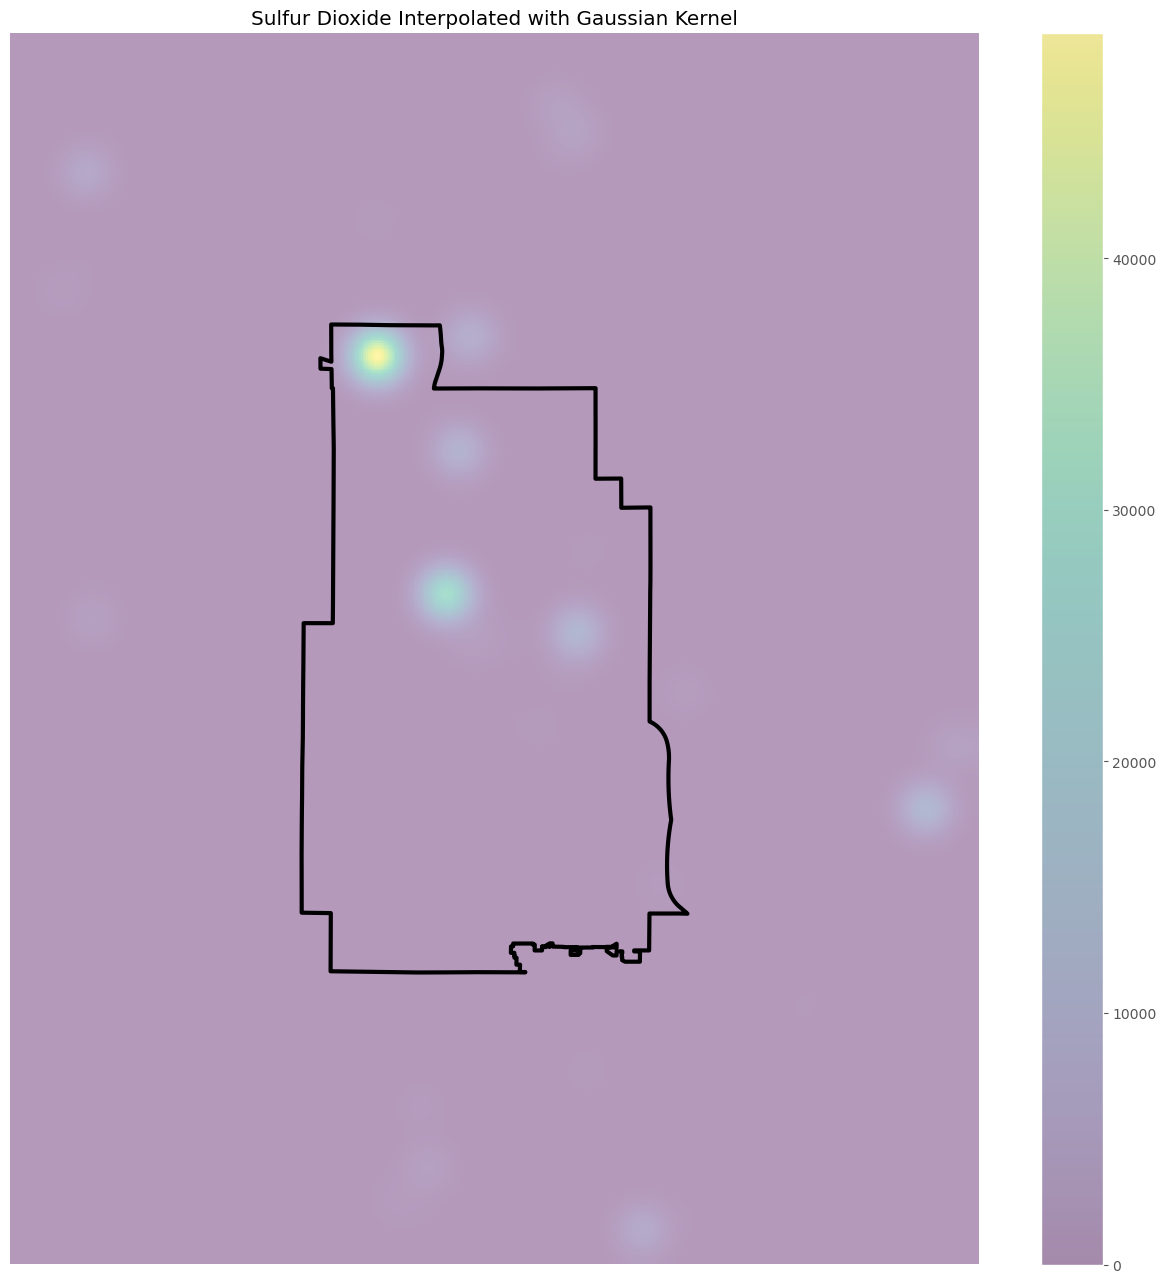

In [5]:
# PLOT!

for pollutant_name in pollutant_names:

    f, ax = plt.subplots(1, figsize=(16,16)) # Initialize frame
    
    print(pollutant_bands[pollutant_name].max())

    art = ax.pcolormesh(raster[0], raster[1], interp_pollutants[pollutant_name].T, shading='auto', cmap = 'viridis', alpha = 0.4) # Plot interpolation

    f.colorbar(art, ax = ax) # Add colorbar
    title = pollutant_name + ''' Interpolated with Gaussian Kernel'''
    ax.set_title(title) # Add title
    ax.set_axis_off()

    mpls.plot(ax = ax,
             edgecolor='black', facecolor='none',
             linewidth=3,
             zorder = 2,
             legend = True)

    # Add basemap

    contextily.add_basemap(ax = ax, 
                           crs = 'EPSG:26915', 
                           source=contextily.providers.CartoDB.Voyager
                          ) 

    plt.show()

## Explore Raster Statistics

They're all crazy heavy tailed

Sulfur Dioxide


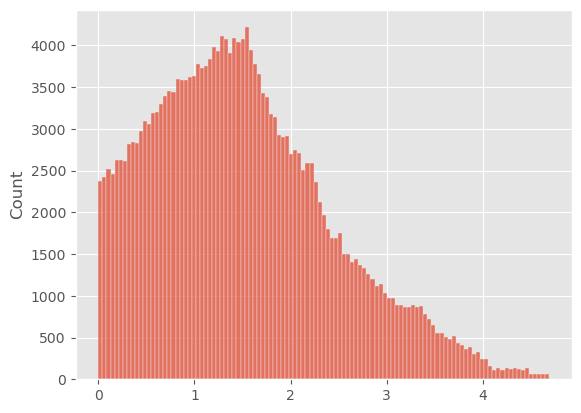

PM Primary


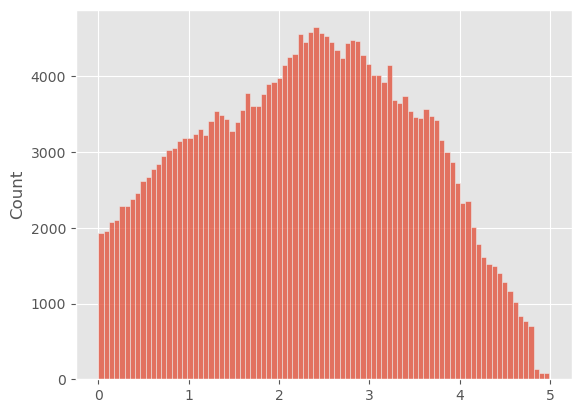

PM10 Primary


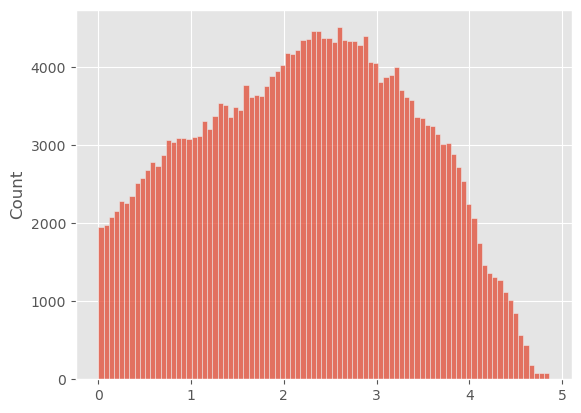

PM2.5 Primary


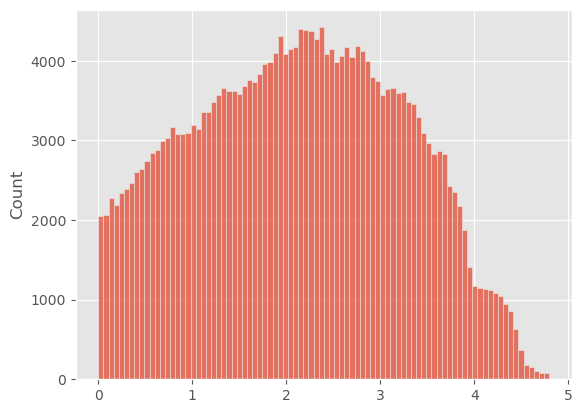

Volatile Organic Compounds


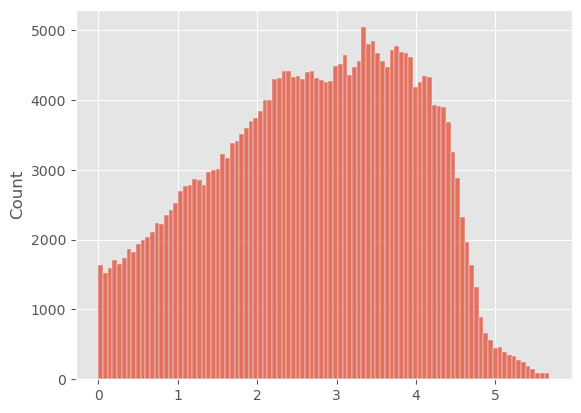

In [6]:
# Heavy tail, remove values less than 1 and try logarithm?

for pollutant_name in pollutant_names:
    
    print(pollutant_name)
    
    interp = interp_pollutants[pollutant_name]
    
    values = interp.flatten()
    
    big_values = values[values>1]

    big_values_log = np.log10(big_values)

    sns.histplot(big_values_log)
    plt.show()

In [7]:
# They're all pretty well distributed now...

## Standardize

In [8]:
# std_rasts = {}

# for pollutant_name in pollutant_names:
    
#     interp = interp_pollutants[pollutant_name]
    
#     std_rast = interp.copy()

#     small_indices = interp<1
#     big_indices = interp>1
#     big_indices_sum = interp[big_indices].sum()

#     std_rast[small_indices] = 0
#     std_rast[big_indices] = np.log10(std_rast[big_indices])

#     std_rast[big_indices] = std_rast[big_indices]/std_rast[big_indices].max()
    
#     std_rasts[pollutant_name] = std_rast

# Not doing the logarithm

Sulfur Dioxide


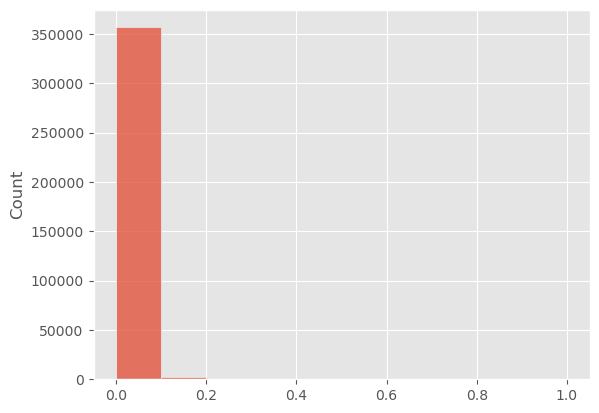

PM Primary


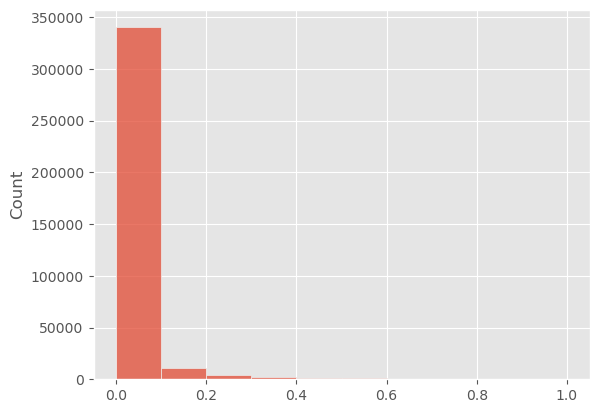

PM10 Primary


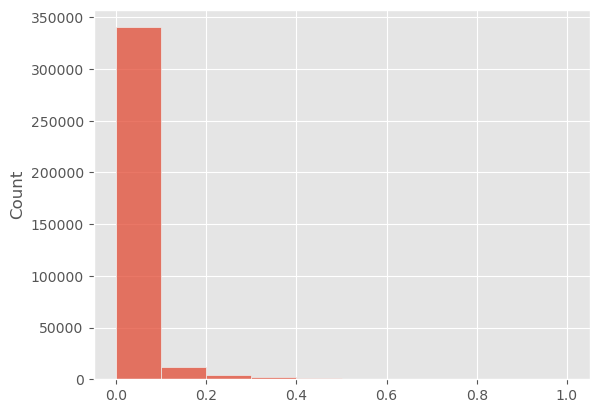

PM2.5 Primary


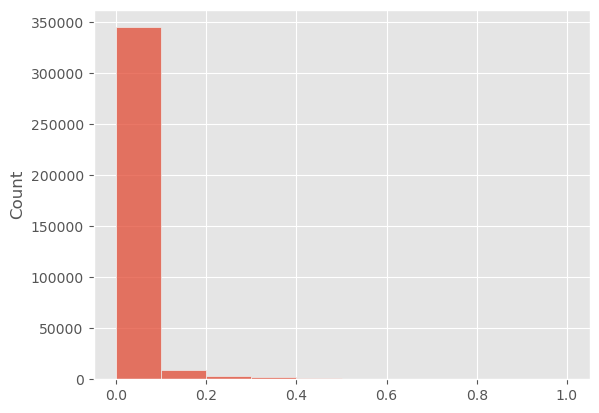

Volatile Organic Compounds


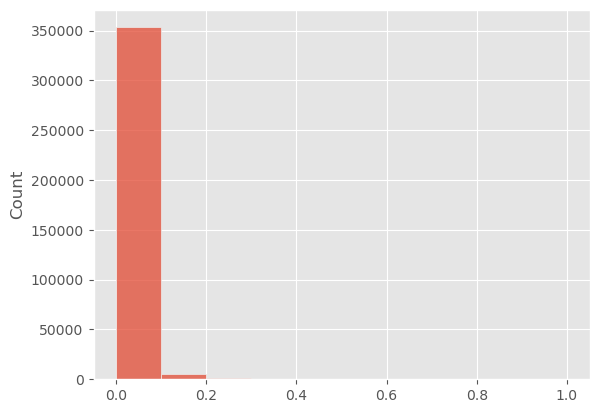

In [11]:
# Just normalizing!!

std_rasts = {}

for pollutant_name in pollutant_names:
    
    interp = interp_pollutants[pollutant_name]
    
    std_rast = interp.copy()

    std_rast = std_rast/std_rast.max()
    
    std_rasts[pollutant_name] = std_rast
    print(pollutant_name)
    sns.histplot(std_rast.flatten(), bins = 10)
    plt.show()

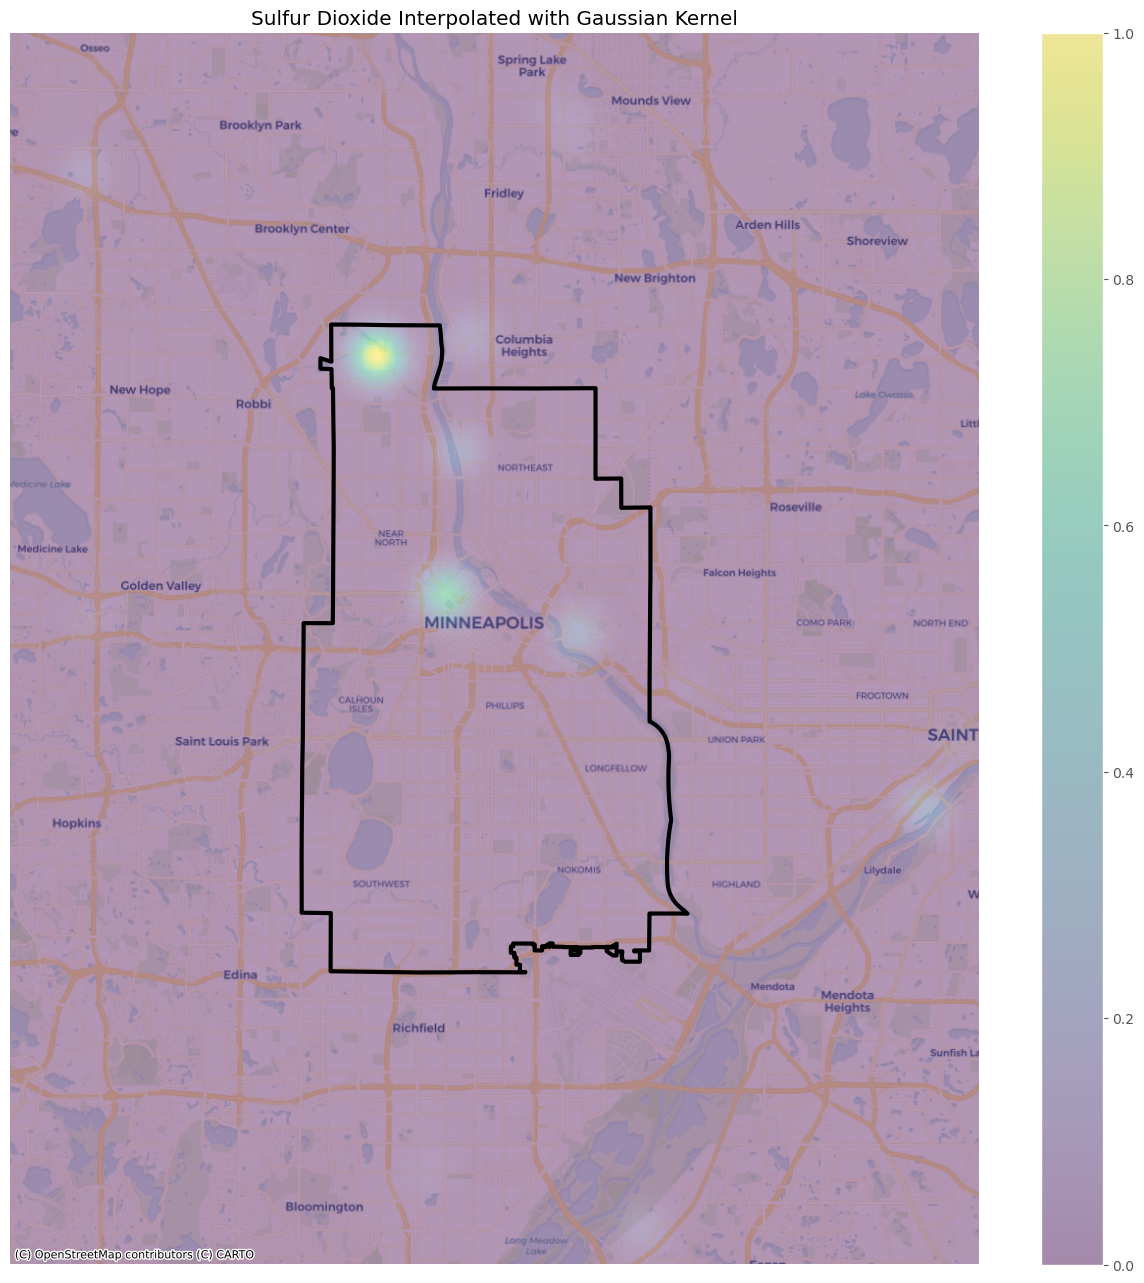

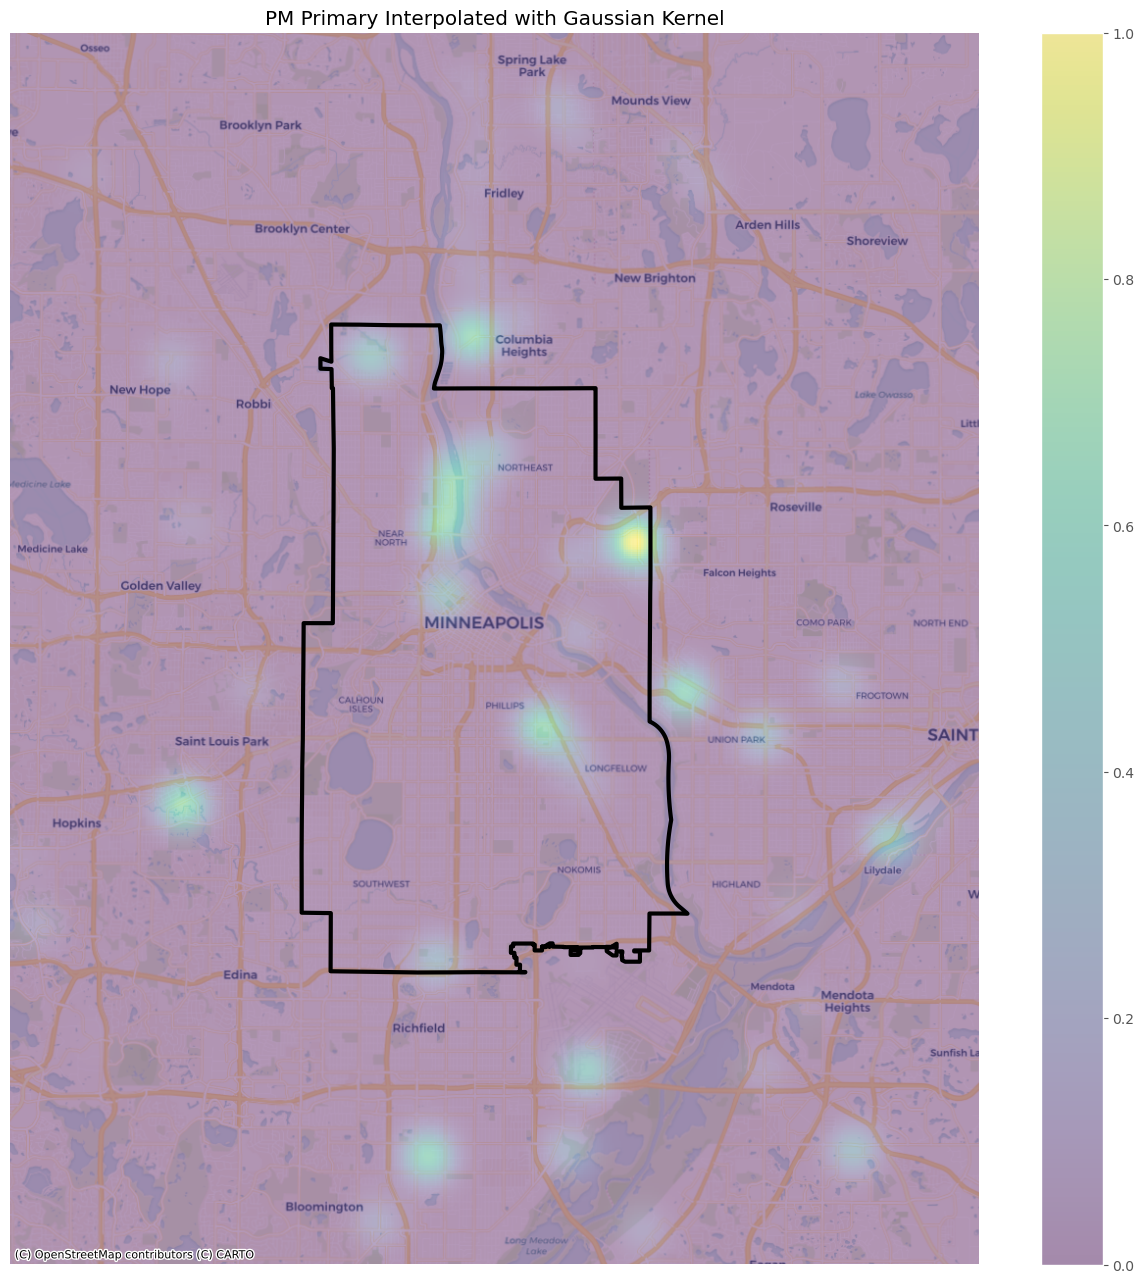

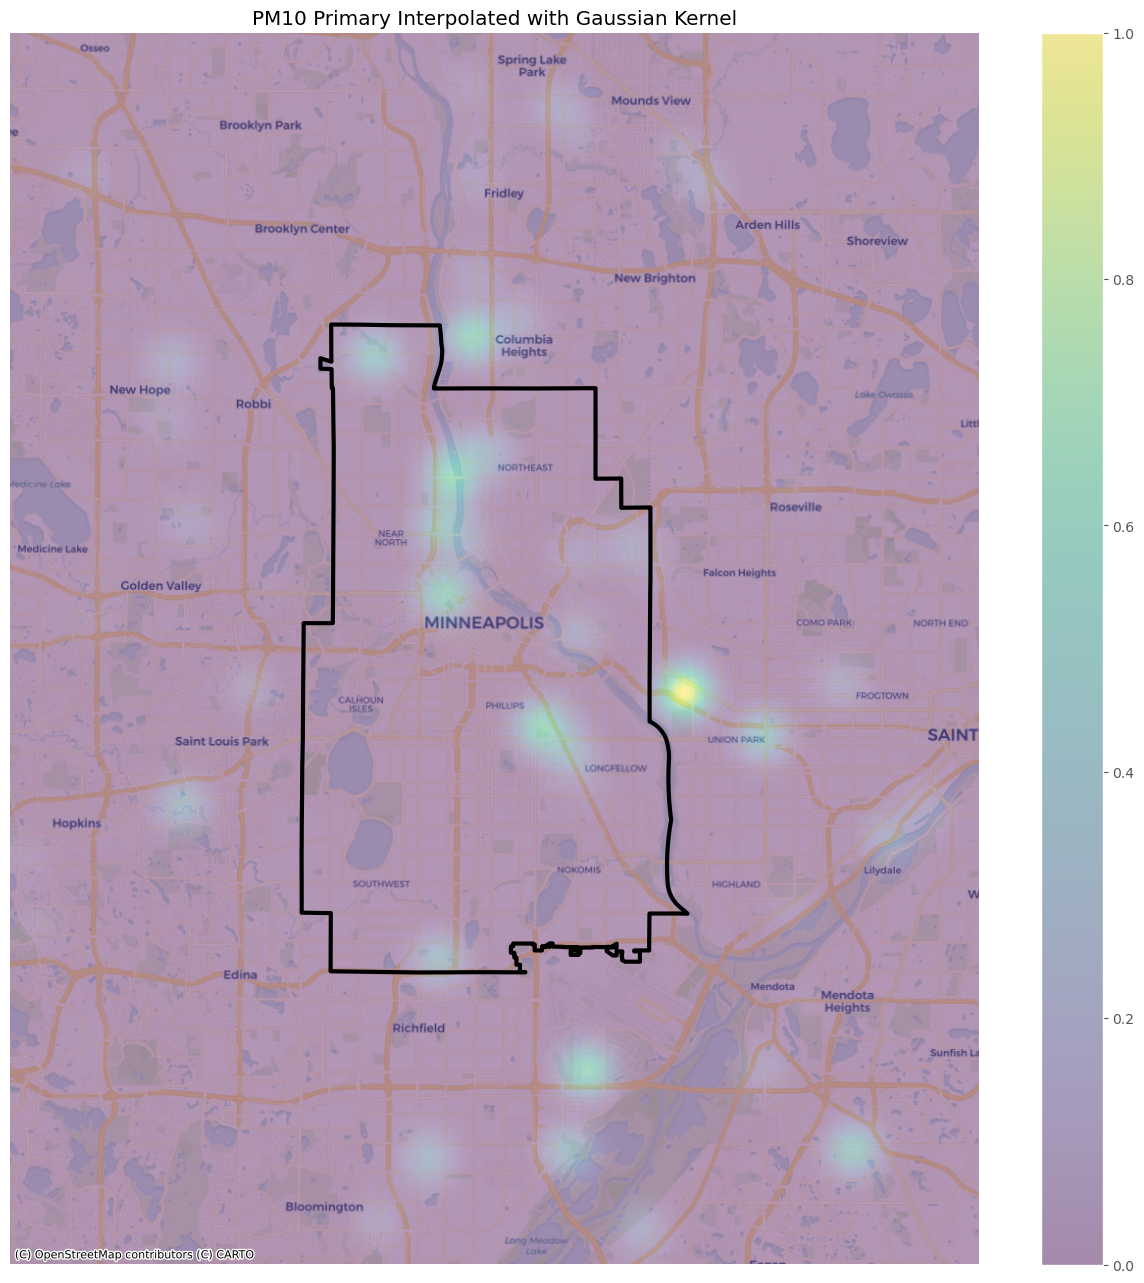

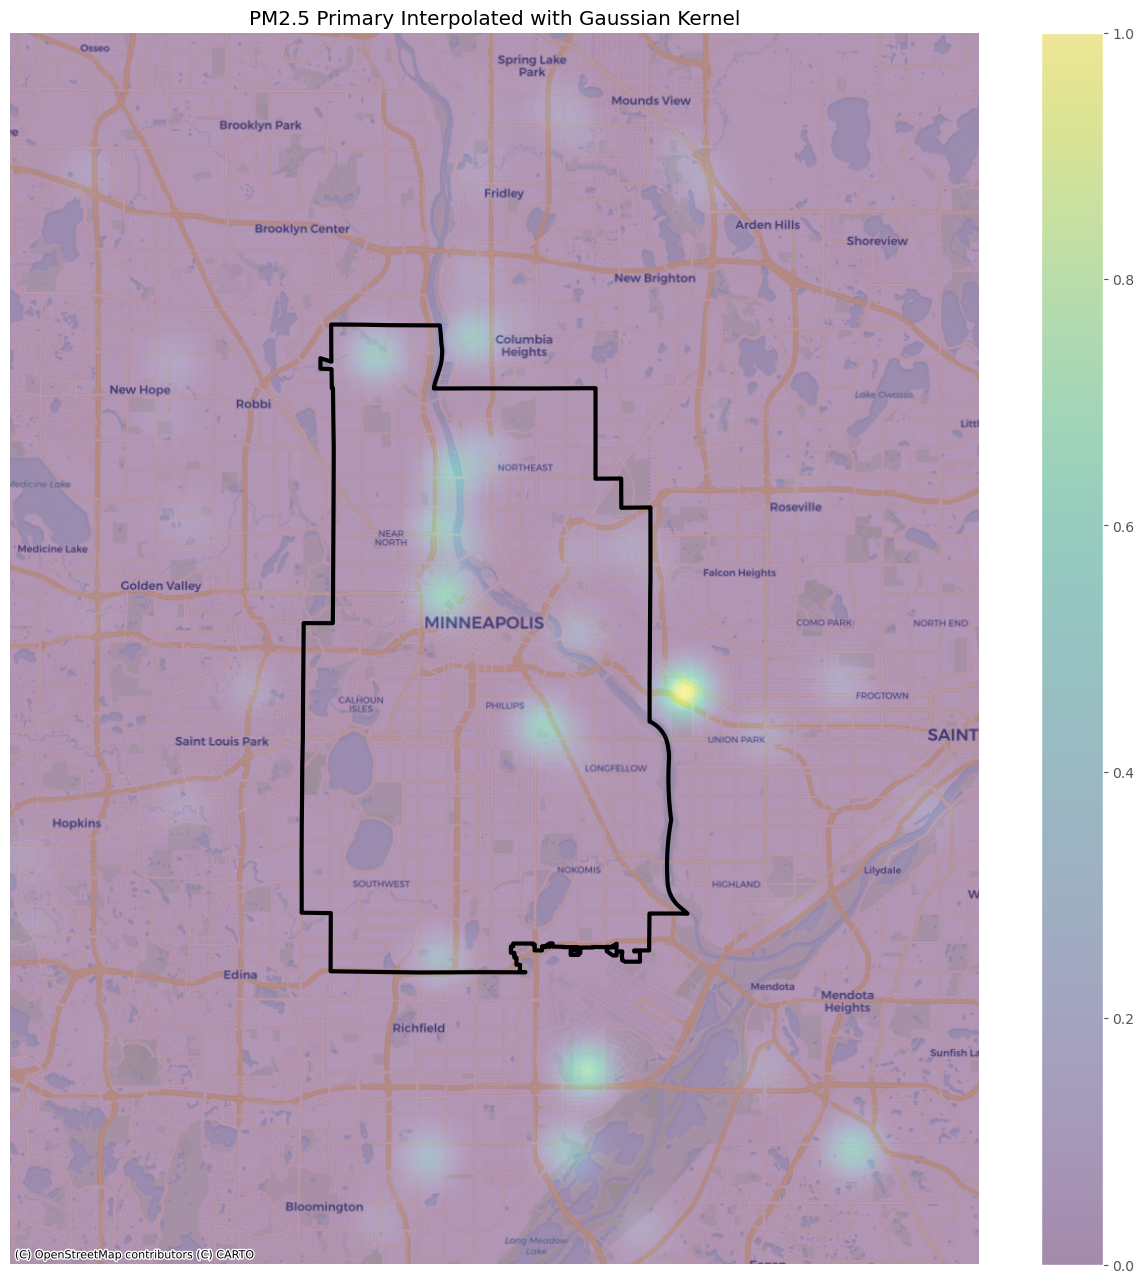

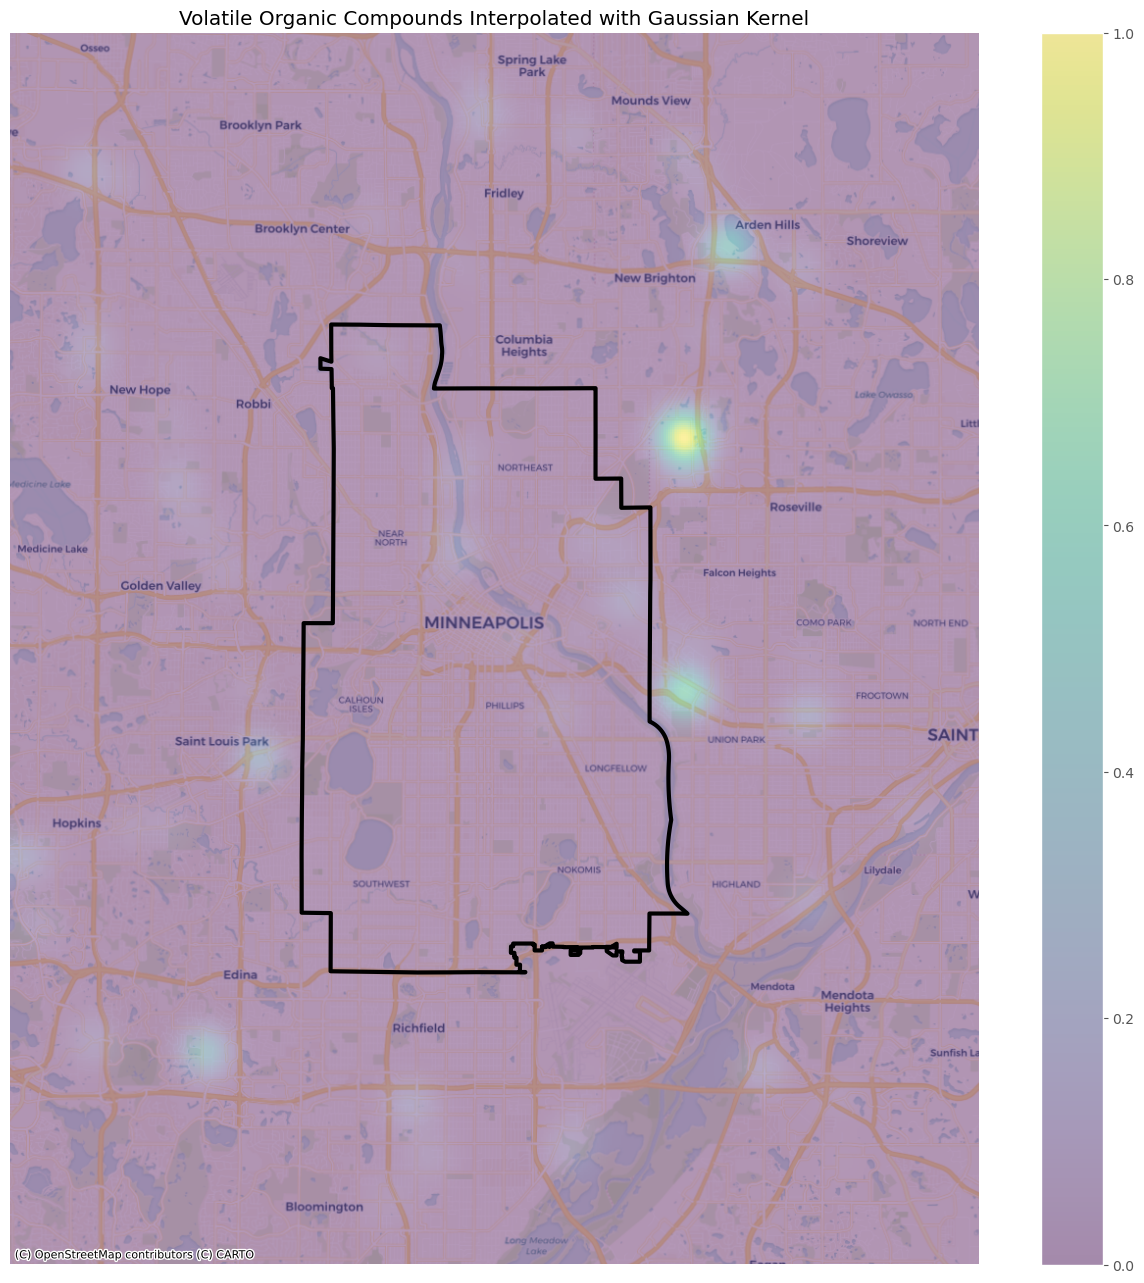

In [10]:
# PLOT!

for pollutant_name in pollutant_names:

    f, ax = plt.subplots(1, figsize=(16,16)) # Initialize frame

    art = ax.pcolormesh(raster[0], raster[1], std_rasts[pollutant_name].T, shading='auto', cmap = 'viridis', alpha = 0.4) # Plot interpolation

    f.colorbar(art, ax = ax) # Add colorbar
    title = pollutant_name + ''' Interpolated with Gaussian Kernel'''
    ax.set_title(title) # Add title
    ax.set_axis_off()

    mpls.plot(ax = ax,
             edgecolor='black', facecolor='none',
             linewidth=3,
             zorder = 2,
             legend = True)

    # Add basemap

    contextily.add_basemap(ax = ax, 
                           crs = 'EPSG:26915', 
                           source=contextily.providers.CartoDB.Voyager
                          ) 

    plt.show()

In [11]:
# Save

for pollutant_name in pollutant_names:
    
    pollutant_savename = pollutant_name.replace('.', '').replace(' ', '')
    

    savename = pollutant_savename+'_current_exposure.tif'
    savepath = '../Modeled_Exposure/' + savename

    Save_array_to_geotiff_template(std_rast, '../template.tif', savepath)

             